In [2]:
%pylab inline
import pickle
from sklearn.cluster import KMeans
from sklearn import preprocessing
import numpy as np
from astropy.table import QTable, Table, Column

Populating the interactive namespace from numpy and matplotlib


In [3]:
path = '/bgfs/akosowsky/yig20/shared/pickle_files/pa5_f090_s19_c11_v0_results.pickle'
with open(path, 'rb') as f:
    data = pickle.load(f, encoding = 'latin1')
data.keys()

dict_keys(['name', 'scan_freq', 'sel', 'psel', 'resp', 'resp_sel', 'cal', 'ctime', 'alt', 'pwv', 'tod_sel', 'gainLive', 'gainLive_sel', 'corrLive', 'corrLive_sel', 'normLive', 'normLive_sel', 'rmsLive', 'rmsLive_sel', 'kurtLive', 'kurtLive_sel', 'skewLive', 'skewLive_sel', 'MFELive', 'MFELive_sel', 'DELive', 'DELive_sel', 'jumpLive', 'jumpLive_sel', 'live', 'dark', 'ff', 'ff_sel', 'stable', 'tes_sel'])

In [4]:
features_list = ['gainLive', 'rmsLive', 'kurtLive', 'normLive', 'skewLive', 'MFELive', 'DELive','corrLive','jumpLive']

# number of dets
ndets = data['gainLive'].shape[0]

# tod selection: choose three tods
tod_sel = np.array([0,2300,4600,13800,6900])
# need to have another array that tells me which TOD i'm look at
# it looks like [0,0,...,0,2300,2300,...,2300]
tod_id = np.repeat(tod_sel, ndets)
# need to have another array that tells me the detector id for each data
# it looks like [0,1,2,...,...3519]
det_id = np.arange(ndets*len(tod_sel))
# stack the features
features = np.hstack([data[feat][:,tod_sel].reshape(-1,1, order = 'F') for feat in features_list])
# get final detector cuts (sel)
sel = np.hstack([data['sel'][:,i] for i in tod_sel])
# mask a mask for sel == 1 (good detectors)
mask_good = (sel == 1)

# make a mask for valid gains (first column in features)
mask_valid = np.hstack([data['gainLive'][:,i] !=0 for i in tod_sel])
# restrict to gain !=0 only
# use log for jump
#print(stand_features.dtype)
#scaler = StandardScaler()
#scaler.fit(features1)
##trying to save the scaler so I dont have to use code like below
#fitted_data = (scaler.transform(features1))
#stand_features = preprocessing.scale(features1, axis=0)

pwv = data['pwv']

### Begin PWV Investigation

In [6]:
#data['jumpLive'] *= 1e15

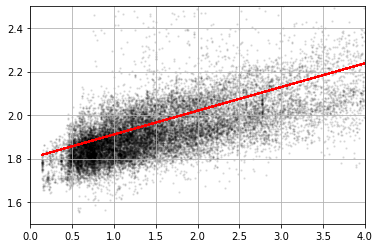

The slope is:  [0.10912056 1.80180252]
The slope is:  [0.00362651 1.02674669]  for  Gain
The slope is:  [0.10912056 1.80180252]  for  RMS
The slope is:  [0.00726926 1.13655699]  for  Kurt
The slope is:  [2176.75586143 -374.92354703]  for  Norm
The slope is:  [ 0.00678518 -0.00951298]  for  Skew
The slope is:  [1.60563845 1.50235957]  for  MFE
The slope is:  [27.6771353  13.82872207]  for  DE
The slope is:  [8.98254736e-04 9.95157653e-01]  for  Corr
The slope is:  [1.67432959e-16 2.49226101e-15]  for  Jump


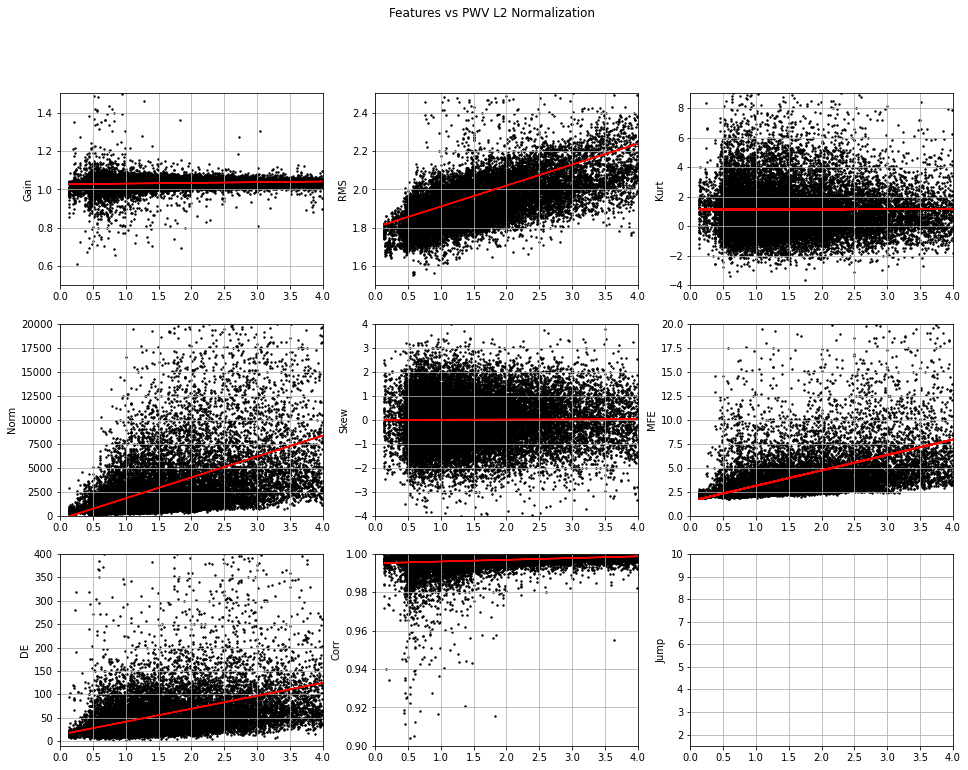

In [7]:
from scipy.optimize import curve_fit
def linear(x,m,b):
    return (m * x) + b
curve_sel = data['sel'][736]
popt,pcov = curve_fit(linear, pwv[curve_sel], data['rmsLive'][736][curve_sel])
plt.plot(pwv[curve_sel], linear(pwv[curve_sel], *popt), color = 'red')
plt.scatter(pwv[curve_sel], data['rmsLive'][736][curve_sel], s=2, color = 'k', alpha = 0.09)
plt.ylim(1.5,2.5)
plt.xlim(0,4)
plt.grid()
plt.show()
print("The slope is: ", popt)

labels = ['Gain','RMS','Kurt','Norm','Skew','MFE','DE','Corr','Jump']
fields = ['gainLive','rmsLive','kurtLive','normLive','skewLive','MFELive','DELive','corrLive','jumpLive']
limits = [[0.5,1.5],[1.5,2.5],[-4,9],[0,20000], [-4,4], [0,20], [-10,400],[0.90,1],[1.5,10]]
fig, axes = plt.subplots(3,3, figsize=(16,12))
i = 736

for lbl, fld, lms, ax in zip(labels, fields, limits, axes.flat):
    sel = data['sel'][i]
    popt,pcov = curve_fit(linear, pwv[sel], data[fld][i][sel])
    ax.scatter(pwv[sel], data[fld][i][sel], s=2, color = 'black')
    ax.plot(pwv[sel], linear(pwv[sel], *popt), color = 'red')
    ax.set_ylabel(lbl)
    ax.set_xlim(0,4)
    ax.set_ylim(lms)
    ax.grid()
    print("The slope is: ", popt, " for ", lbl)
fig.suptitle("Features vs PWV L2 Normalization")
plt.show()

### L2 Normalization (Scipy's Curve Fitting) isnt as Robust as desired. Moving to L1 Normalization

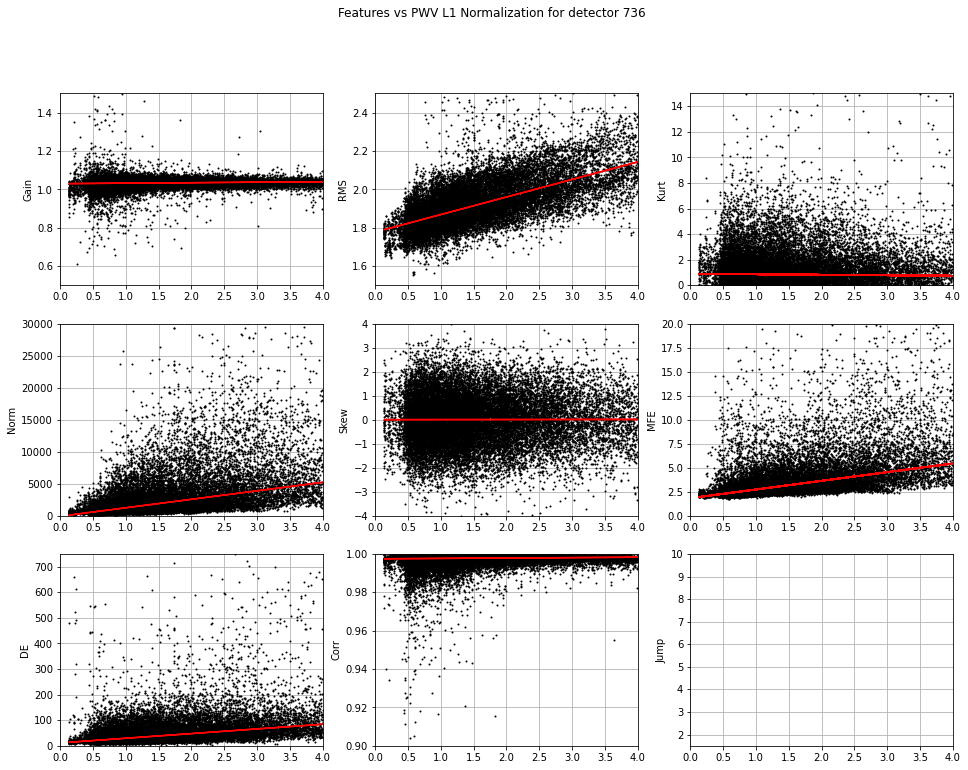

In [8]:
from scipy.optimize import minimize

def fit(x, params):
    return params[0]*x + params[1]
def cost_function(params, X, y):
    return np.sum(np.abs(y - fit(X, params)))


labels = ['Gain','RMS','Kurt','Norm','Skew','MFE','DE','Corr','Jump']
fields = ['gainLive','rmsLive','kurtLive','normLive','skewLive','MFELive','DELive','corrLive','jumpLive']
limits = [[0.5,1.5],[1.5,2.5],[0,15],[0,30000], [-4,4], [0,20], [0,750],[0.90,1], [1.5,10]]
fig, axes = plt.subplots(3,3, figsize=(16,12))
i = 736

for lbl, fld, lms, ax in zip(labels, fields, limits, axes.flat):
    sel = data['sel'][i]
    X = pwv[curve_sel]
    y = data[fld][i][curve_sel]
    output = minimize(cost_function, (0,0), args=(X, y))
    y_hat = fit(X, output.x)
    ax.plot(X, y, 'k.', markersize=2)
    ax.plot(X, y_hat, 'r')
    ax.set_ylabel(lbl)
    ax.set_xlim(0,4)
    ax.set_ylim(lms)
    ax.grid()
fig.suptitle("Features vs PWV L1 Normalization for detector 736")
plt.show()

### Investigating how the fit changes with detectors 

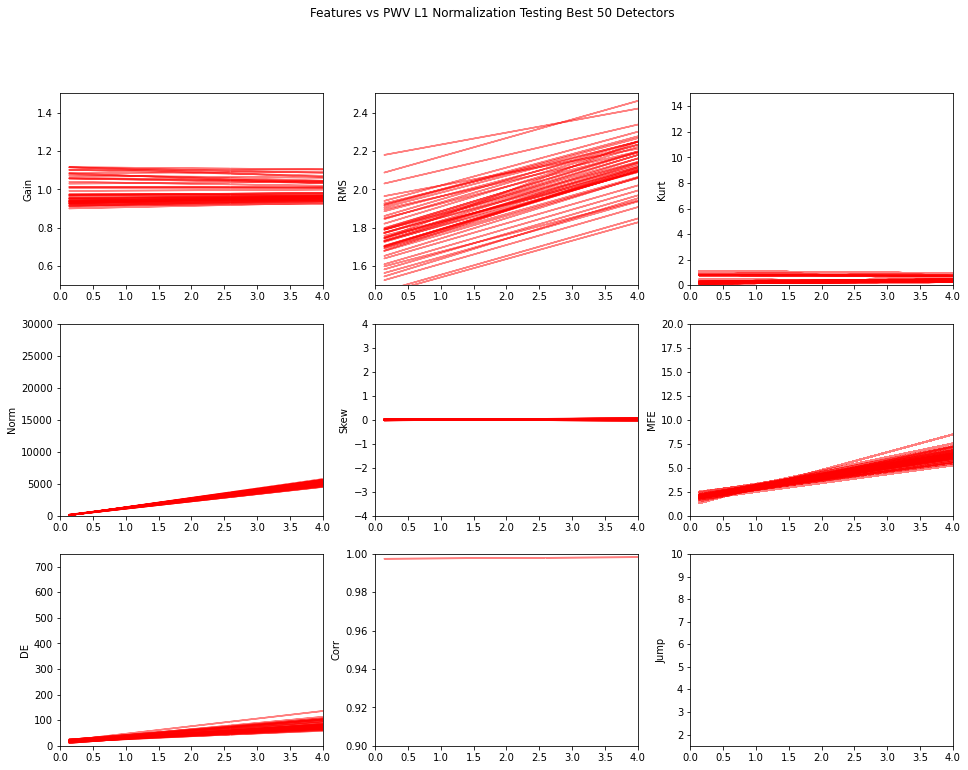

In [9]:
labels = ['Gain','RMS','Kurt','Norm','Skew','MFE','DE','Corr','Jump']
fields = ['gainLive','rmsLive','kurtLive','normLive','skewLive','MFELive','DELive','corrLive','jumpLive']
limits = [[0.5,1.5],[1.5,2.5],[0,15],[0,30000], [-4,4], [0,20], [0,750],[0.90,1], [1.5,10]]
fig, axes = plt.subplots(3,3, figsize=(16,12))
dets = np.argsort(np.sum(data['sel'],axis=1))[-50:]
for i in dets:
	for lbl, fld, lms, ax in zip(labels, fields, limits, axes.flat):
		sel = data['sel'][i]
		X = pwv[curve_sel]
		y = data[fld][i][curve_sel]
		output = minimize(cost_function, (0,0), args=(X, y))
		y_hat = fit(X, output.x)
		ax.plot(X, y_hat, 'r', alpha=0.5)
		ax.set_ylabel(lbl)
		ax.set_xlim(0,4)
		ax.set_ylim(lms)
		ax.grid()
fig.suptitle("Features vs PWV L1 Normalization Testing Best 50 Detectors")
plt.show()

### Yilun's Model that is more robust than L1 Normalization

In [10]:
from scipy import stats

def build_model(data, pwv, dets, nbins=20, pwv_min=0, pwv_max=5):
    # make pwv bins
    pwv_bins   = np.linspace(pwv_min, pwv_max, nbins+1)
    pwv_bins_l = pwv_bins[:-1]
    pwv_bins_r = pwv_bins[1:]
    # empty array to store the resulting model for each det
    model = np.zeros((nbins, len(dets), 2), dtype=float)
    for i, b_l, b_r in zip(np.arange(nbins), pwv_bins_l, pwv_bins_r):
        # find a pwv mask corresponding to the bin
        pmask = (pwv > b_l) * (pwv < b_r)
        # retrieve the data at this given pwv bin
        # pmask applies to tod axis; data has shape (ndet, ntod)
        y = data[dets][:,pmask]
        # compute median and std (using iqr)
        m = np.median(y, axis=1)
        s = 0.741*stats.iqr(y, axis=1)
        model[i,dets,0] = m
        model[i,dets,1] = s
    return pwv_bins, model

In [11]:
dets  = np.sum(data['sel'], axis=1) > 0
bins, model = build_model(data['rmsLive'], data['pwv'], dets=dets)

/ihome/akosowsky/blc95/.conda/envs/research/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/ihome/akosowsky/blc95/.conda/envs/research/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


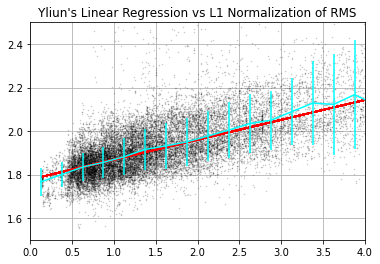

In [12]:
bins_center = (bins[:-1] + bins[1:])/2
pwv = data['pwv']
curve_sel = data['sel'][736]
X = pwv[curve_sel]
y = data['rmsLive'][i][curve_sel]
output = minimize(cost_function, (0,0), args=(X, y))
y_hat = fit(X, output.x)
plt.errorbar(bins_center, model[:,736,0], yerr=model[:,736,1], ecolor='cyan', color='cyan', zorder=10)
plt.plot(X, y, 'k.', markersize=1, alpha = 0.2)
plt.plot(X, y_hat, 'r')
plt.xlim(0,4)
plt.grid()
plt.title("Yliun's Linear Regression vs L1 Normalization of RMS")
plt.ylim(1.5,2.5)
plt.show()


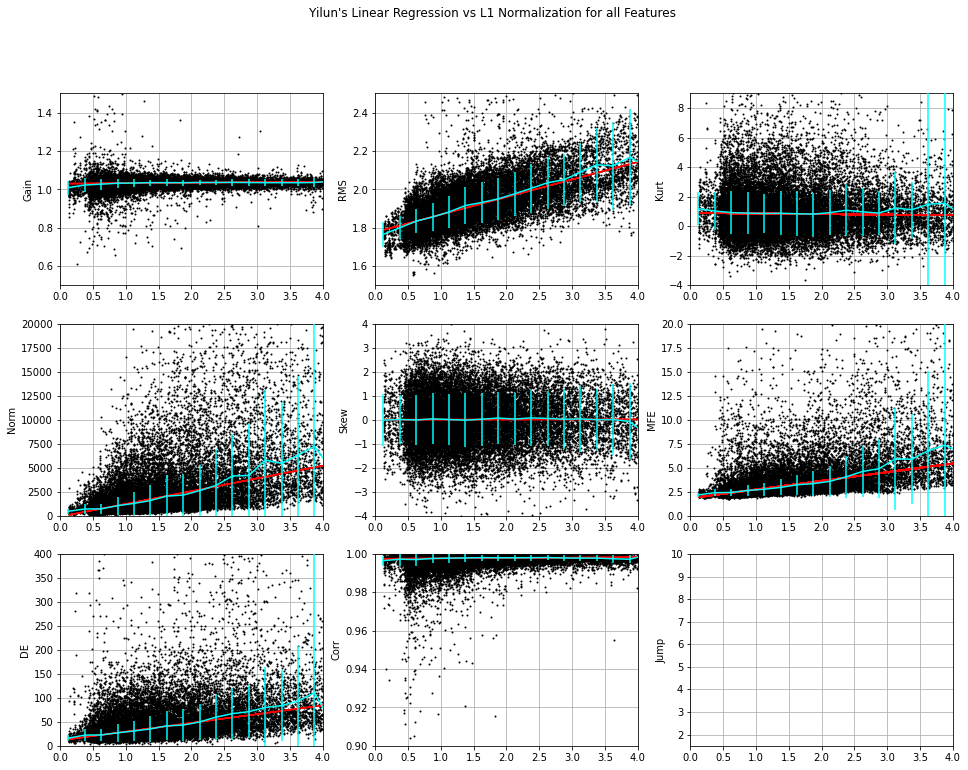

In [13]:
import warnings
warnings.filterwarnings("ignore")

labels = ['Gain','RMS','Kurt','Norm','Skew','MFE','DE','Corr','Jump']
fields = ['gainLive','rmsLive','kurtLive','normLive','skewLive','MFELive','DELive','corrLive','jumpLive']
limits = [[0.5,1.5],[1.5,2.5],[-4,9],[0,20000], [-4,4], [0,20], [0,400],[0.90,1], [1.5,10]]
fig, axes = plt.subplots(3,3, figsize=(16,12))
i = 736


for lbl, fld, lms, ax in zip(labels, fields, limits, axes.flat):
    dets  = np.sum(data['sel'], axis=1) > 0
    bins, model = build_model(data[fld], data['pwv'], dets=dets)
    bins_center = (bins[:-1] + bins[1:])/2
    sel = data['sel'][i]
    X = pwv[curve_sel]
    y = data[fld][i][curve_sel]
    output = minimize(cost_function, (0,0), args=(X, y))
    y_hat = fit(X, output.x)
    ax.plot(X, y, 'k.', markersize=2)
    ax.errorbar(bins_center, model[:,736,0], yerr=model[:,736,1], ecolor='cyan', color='cyan', zorder=10)
    ax.plot(X, y_hat, 'r')
    ax.set_ylabel(lbl)
    ax.set_xlim(0,4)
    ax.set_ylim(lms)
    ax.grid()
fig.suptitle("Yilun's Linear Regression vs L1 Normalization for all Features")
plt.show()

In [14]:
#can use this to find best detectors. Gain mask isnt required
#np.argmax(np.sum(data['sel'][gain_mask],axis=1))

### End of PWV Investigation, Starting ML using Yilun's Model

In [16]:
def apply_model(data, model, pwv, bins):
    for i, b_l, b_r in zip(np.arange(len(bins)-1), bins[:-1], bins[1:]):
        pmask = (pwv > b_l) * (pwv < b_r)
        
        data[:,pmask] -= model[i,:,0][:,None]
        #print("median is: " ,np.median(data[:,pmask]))
        data[:,pmask] /= model[i,:,1][:,None]
        #import pdb;pdb.set_trace()
        #print("std is: " ,np.std(np.isfinite(data[:,pmask])))
    return data


In [17]:
model_list = []
for feat in features_list:
    pwv_bins, model = build_model(data[feat], data['pwv'], dets=dets)
    usable_data = apply_model(data[feat].copy(), model, data['pwv'], bins=pwv_bins)
    model_list.append(usable_data)

In [18]:
stacked_models = np.hstack([model_list[i][:,tod_sel].reshape(-1,1, order = "F") for i in range(9)])
valid_data = stacked_models[mask_valid]
filtered_data = np.nan_to_num(valid_data, nan = 0,posinf=0, neginf=0)

In [31]:
np.std(filtered_data)

46.113144108278725

In [19]:
# choose number of clusters
n_clusters = 9

kmean_stand = KMeans(n_clusters=n_clusters,n_init=500, max_iter=10000,tol=.0001, algorithm = 'full')
kmean_stand.fit(filtered_data)

pred = kmean_stand.predict(filtered_data)
centers = kmean_stand.cluster_centers_

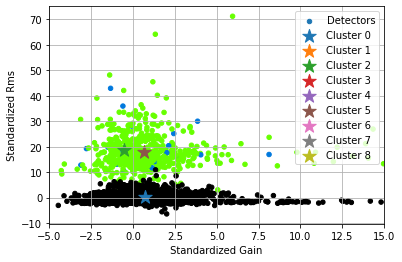

In [20]:
plt.scatter(filtered_data[:,0], filtered_data[:,1], s=20, c=pred, label = 'Detectors', cmap='nipy_spectral')
for i in range(n_clusters):
    plt.scatter(centers[i, 0], centers[i, 1], s = 200, label = f'Cluster {i}', marker = '*')
plt.xlabel(" Standardized Gain ")
plt.ylabel(" Standardized Rms ")
plt.xlim(-5,15)
plt.legend()
plt.grid()
plt.show()

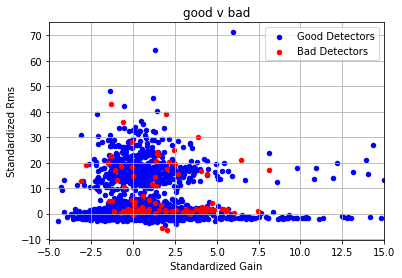

In [21]:
good = mask_good[mask_valid]

plt.scatter(filtered_data[:,0][good], filtered_data[:,1][good], s=20, c='b', label = 'Good Detectors')
plt.scatter(filtered_data[:,0][~good], filtered_data[:,1][~good], s=20, c='r', label = 'Bad Detectors')
plt.xlabel(" Standardized Gain ")
plt.ylabel(" Standardized Rms ")
plt.title('good v bad')
plt.xlim(-5,15)
plt.legend()
plt.grid()
plt.show()

In [22]:
def load_tod_data(tod_list, ds=10):
    # here the tod list is to be replaced with your list of tod names
    # such as ['/bgfs/akosowsky/yig20/shared/pickle_files/1551491060.1551501304.ar5.pkl',...]
    # they need to be in the right order that's compatible with good / bad mask
    # here ds means downsample factor in time stream
    datas = []
    for todname in tod_list:
        with open(todname, "rb") as f:
            tmp = pickle.load(f, encoding='latin1')['data']
        datas.append(tmp[:,::ds])
        del tmp
    # stacked them accordingly
    minl = min([d.shape[-1] for d in datas])
    datas = np.vstack([d[:,:minl] for d in datas])
    return datas

In [23]:
##using this to find the name for the tod order
tod_list = [0,2300,4600,13800,6900] 
for i in tod_list:
    print(data['name'][i])

1551491060.1551501304.ar5
1553201737.1553211922.ar5
1555590950.1555601987.ar5
1564964420.1564973790.ar5
1559791186.1559801171.ar5


In [24]:
TODS = np.array(['/bgfs/akosowsky/yig20/shared/pickle_files/1551491060.1551501304.ar5.pkl',
                '/bgfs/akosowsky/yig20/shared/pickle_files/1553201737.1553211922.ar5.pkl',
                '/bgfs/akosowsky/yig20/shared/pickle_files/1555590950.1555601987.ar5.pkl',
                '/bgfs/akosowsky/yig20/shared/pickle_files/1564964420.1564973790.ar5.pkl',
                '/bgfs/akosowsky/yig20/shared/pickle_files/1559791186.1559801171.ar5.pkl'])
'''

TODS = np.array(['/bgfs/akosowsky/yig20/shared/pickle_files/1559791186.1559801171.ar5.pkl',
               '/bgfs/akosowsky/yig20/shared/pickle_files/1562165331.1562175449.ar5.pkl',
                '/bgfs/akosowsky/yig20/shared/pickle_files/1563541466.1563551634.ar5.pkl'])
'''

"\n\nTODS = np.array(['/bgfs/akosowsky/yig20/shared/pickle_files/1559791186.1559801171.ar5.pkl',\n               '/bgfs/akosowsky/yig20/shared/pickle_files/1562165331.1562175449.ar5.pkl',\n                '/bgfs/akosowsky/yig20/shared/pickle_files/1563541466.1563551634.ar5.pkl'])\n"

In [25]:
stacked_tods = load_tod_data(TODS)


#cali1 = cal[:,0][:,None]
#cali2 = cal[:,2300][:,None]
#cali3 = cal[:,4600][:,None]
#cali4 = cal[:,13800][:,None]
cali = np.vstack([data['cal'][:,i].reshape(-1,1, order = 'F') for i in tod_sel])
stacked_tods -= stacked_tods.mean(axis=1)[:,None]
stacked_tods *= cali

In [26]:
cali.shape

(8800, 1)

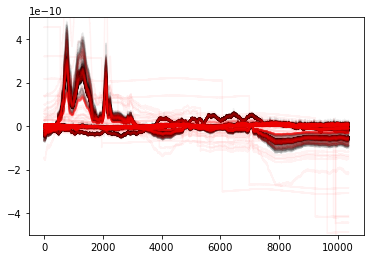

In [27]:
good = mask_good * mask_valid
bad  = (~mask_good) * mask_valid
plt.plot(stacked_tods[good].T, c='k', alpha=0.05)
plt.plot(stacked_tods[bad].T, c='r', alpha=0.05)
plt.ylim(-5e-10,5e-10)
plt.show()

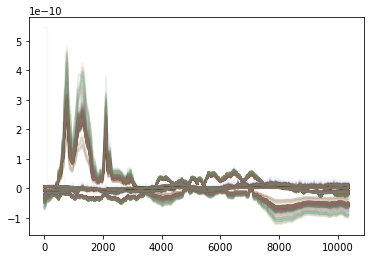

In [143]:
plt.plot(stacked_tods[sel==1].T, alpha=0.05)
plt.show()

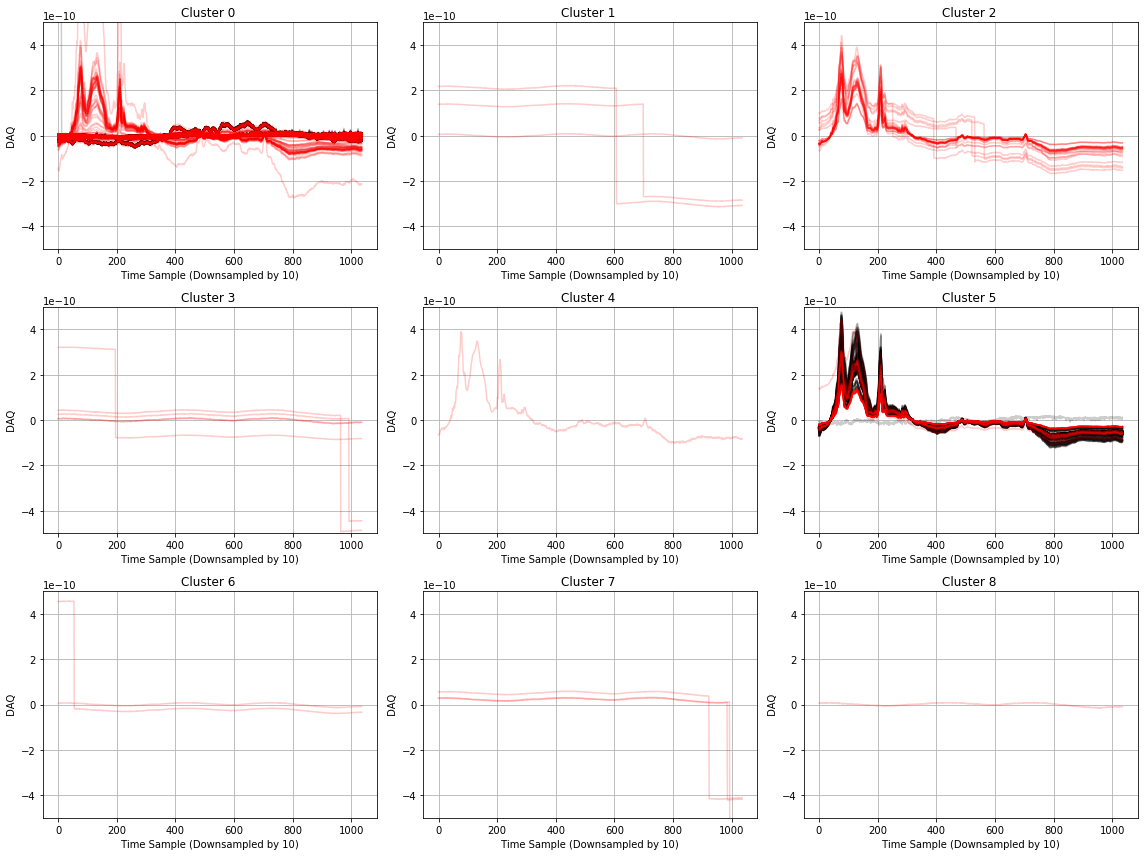

In [28]:
ncol = 3
nrow = int(np.ceil(n_clusters / 3)) 
plt.figure(figsize=(16,12))
for i in range(n_clusters):
    plt.subplot(nrow, ncol, i+1)
    # get the mask representing this cluster
    mask_pred = pred == i
    # get valid detectors
    det_valid = det_id[mask_valid]
    # get good detector mask (and valid)
    mask_sel = mask_good[mask_valid]
    good_ = det_valid[(mask_pred * mask_sel)]
    bad_ = det_valid[(mask_pred * (~mask_sel))]
    if len(good_) > 0: plt.plot(stacked_tods[good_, ::10].T, c='k', alpha=.2)
    if len(bad_) > 0: plt.plot(stacked_tods[bad_, ::10].T, c='r', alpha=.2)
    plt.ylim(-.5e-9,.5e-9)
    plt.grid()
    plt.ylabel(" DAQ ")
    plt.xlabel(" Time Sample (Downsampled by 10) ")
    plt.title(f"Cluster {i} ")
#plt.legend()
plt.tight_layout()
plt.show()

In [29]:
sel_list=[]
det_list=[]
bad_list=[]


for i in range(n_clusters):
    sel=np.sum(pred[mask_sel]==i)
    sel_list.append(sel)
    
    det=np.sum(pred==i)
    det_list.append(det)
    
    bad=np.sum(pred==i)-np.sum(pred[mask_sel]==i)
    bad_list.append(bad)
cluster = np.arange(9)
Sel = np.array(sel_list)
Det = np.array(det_list)
Bad = np.array(bad_list)

percent = np.array((Sel/Det)*100)
percent = np.round(percent, 2)
t = Table([cluster,Det,Sel,Bad,percent], names = ( 'Cluster Number', 'Amount of Detectors','Amount of Good Detectors','Amount of Bad Detectors','Percent of Good Detectors'))

In [30]:
t

Cluster Number,Amount of Detectors,Amount of Good Detectors,Amount of Bad Detectors,Percent of Good Detectors
int64,int64,int64,int64,float64
0,2807,2527,280,90.02
1,3,0,3,0.0
2,26,0,26,0.0
3,5,0,5,0.0
4,1,0,1,0.0
5,631,598,33,94.77
6,2,0,2,0.0
7,3,0,3,0.0
8,1,0,1,0.0


### Part 2: Predicting a New TOD

In [117]:
##redoing the code for a prediction 
##NOTE that I wrote down the good/bad clusters as a flag, not sure if that was your vision for a flag or not.
tod_predict = np.array([9200])

tod_id_predict = np.repeat(tod_predict, ndets)

det_id_pred = np.arange(ndets*len(tod_predict))


sel_predict = np.hstack([data['sel'][:,i] for i in tod_predict])

mask_good_predict = (sel_predict == 1)

mask_valid_predict = np.hstack([data['gainLive'][:,i] !=0 for i in tod_predict])

##This is where I could be messing up and not using scaler the right way
data_predict = np.hstack([model_list[i][:,tod_predict].reshape(-1,1, order = "F") for i in range(9)])
filtered_data_predict = np.nan_to_num(data_predict, nan=0 ,posinf=0, neginf=0)


In [120]:
np.sum(np.isinf(filtered_data_predict))

0

In [121]:
pred_new = kmean_stand.predict(filtered_data_predict)

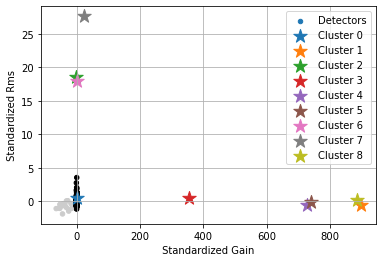

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1760 but corresponding boolean dimension is 754

In [122]:
plt.scatter(filtered_data_predict[:,0], filtered_data_predict[:,1], s=20, c=pred_new, label = 'Detectors', cmap='nipy_spectral')
for i in range(n_clusters):
    plt.scatter(centers[i, 0], centers[i, 1], s = 200, label = f'Cluster {i}', marker = '*')
plt.xlabel(" Standardized Gain ")
plt.ylabel(" Standardized Rms ")
plt.legend()
plt.grid()
plt.show()

good = mask_good_predict[mask_valid_predict]

plt.scatter(filtered_data_predict[:,0][good], filtered_data_predict[:,1][good], s=20, c='b', label = 'Good Detectors')
plt.scatter(filtered_data_predict[:,0][~good], filtered_data_predict[:,1][~good], s=20, c='r', label = 'Bad Detectors')

plt.xlabel(" Standardized Gain ")
plt.ylabel(" Standardized Rms ")
plt.title('good v bad prediction (TOD 9200)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
TOD = np.array(['/bgfs/akosowsky/yig20/shared/pickle_files/1562165331.1562175449.ar5.pkl'])

tod9200 = load_tod_data(TOD)

cal_9200 = np.vstack([data['cal'][:,i].reshape(-1,1, order = 'F') for i in tod_predict])

tod9200 -= tod9200.mean(axis=1)[:,None]

tod9200 *= cal_9200

In [ ]:
plt.plot(tod9200[sel_predict==1].T, alpha=0.05)
plt.ylim(-.3e-10,.3e-10)
plt.show()

In [ ]:
ncol = 3
nrow = int(np.ceil(n_clusters / 3)) 
plt.figure(figsize=(16,12))
for i in range(n_clusters):
    plt.subplot(nrow, ncol, i+1)
    # get the mask representing this cluster
    mask_pred_9200 = pred_new == i
    # get valid detectors
    det_valid_9200 = det_id_pred[mask_valid_predict]
    # get good detector mask (and valid)
    mask_sel_9200 = mask_good_predict[mask_valid_predict]
    good__ = det_valid_9200[(mask_pred_9200 * mask_sel_9200)]
    bad__ = det_valid_9200[(mask_pred_9200 * (~mask_sel_9200))]
    if len(good__) > 0: plt.plot(tod9200[good__, ::10].T, c='k', alpha=.05)
    if len(bad__) > 0: plt.plot(tod9200[bad__, ::10].T, c='r', alpha=.05)
    plt.ylim(-.3e-10,.3e-10)
    plt.grid()
    plt.ylabel(" DAQ ")
    plt.xlabel(" Time Sample (Downsampled by 10) ")
    plt.title(f"Cluster {i} ")
#plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
sel_list_9200=[]
det_list_9200=[]
bad_list_9200=[]


for i in range(n_clusters):
    sel_9200=np.sum(pred_new[mask_sel_9200]==i)
    sel_list_9200.append(sel_9200)
    
    det_9200=np.sum(pred_new==i)
    det_list_9200.append(det_9200)
    
    bad_9200=np.sum(pred_new==i)-np.sum(pred_new[mask_sel_9200]==i)
    bad_list_9200.append(bad_9200)
cluster = np.arange(9)
Sel_9200 = np.array(sel_list_9200)
Det_9200 = np.array(det_list_9200)
Bad_9200 = np.array(bad_list_9200)

percent_9200 = np.array((Sel_9200/Det_9200)*100)
percent_9200 = np.round(percent_9200, 2)
t = Table([cluster,Det_9200,Sel_9200,Bad_9200,percent_9200], names =( 'Cluster Number', 'Amount of Detectors','Amount of Good Detectors','Amount of Bad Detectors','Percent of Good Detectors'))

In [ ]:
t